In [8]:
import pandas as pd
import numpy as np
from pprint import pprint

from utils import get_dfs, concat_output_filename, load_head_items
from prep_organized_boycotts import (
    group_by_age, group_by_gender, group_by_genre,
    group_by_occupation, group_by_power, group_by_state, group_by_genre_strict
)

In [9]:
dfs = get_dfs('ml-1m')

Path to ratings file is: C:\Users\Nick/.surprise_data/ml-1m/ml-1m/ratings.dat


In [10]:
users_df = dfs['users']
ratings_df = dfs['ratings']
print(users_df.head())
print(ratings_df.head())

   user_id gender  age  occupation zip_code
0        1      F    1          10    48067
1        2      M   56          16    70072
2        3      M   25          15    55117
3        4      M   45           7    02460
4        5      M   25          20    55455
   user_id  movie_id  rating  unix_timestamp
0        1      1193       5       978300760
1        1       661       3       978302109
2        1       914       3       978301968
3        1      3408       4       978300275
4        1      2355       5       978824291


Mean
rating    3.581564
dtype: float64
Mean Along Users
3.7027048669997265
3706


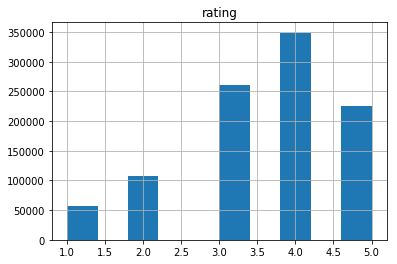

In [11]:
import matplotlib.pyplot as plt
ratings_df[['rating']].hist()
print('Mean')
print(ratings_df[['rating']].mean())
print('Mean Along Users')
user_to_mean = ratings_df.groupby(['user_id']).mean()[['rating']]
print(np.mean(user_to_mean.rating))

print(len(ratings_df.groupby(['movie_id'])))

plt.show()

In [12]:
print(ratings_df[['rating']].count().mean())
print('Counts')
count_ratings = ratings_df.groupby(['movie_id']).count().rating.mean()
count_hits = ratings_df[ratings_df.rating>=4].groupby(['user_id']).count().rating.mean()
print(count_ratings, count_hits)
print(count_ratings/5, count_hits/5)


1000209.0
Counts
269.88909875876953 95.27674726730706
53.977819751753906 19.05534945346141


C:\Users\Nick\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


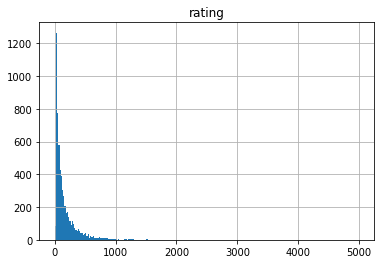

In [13]:
ratings_df[['user_id', 'rating']].groupby(['user_id']).count().hist(bins=np.linspace(0, 5000, 5000/20))
plt.show()

In [14]:
tmp = ratings_df[['user_id', 'rating']].groupby(['user_id']).count()
tmp2 = tmp[(tmp.rating >= 20) & (tmp.rating < 500)]
tmp3 = tmp[(tmp.rating >= 1000) & (tmp.rating < 2000)]
print(sum(tmp2.rating))
print(sum(tmp3.rating))

709900
48579


In [15]:


count = len(ratings_df[ratings_df.rating >=4])
print(count)
counts = []
for name, group in ratings_df.groupby(['user_id']):
    count = len(group[group.rating >= 4].index) / len(group.index)
    #print(count)
    counts.append(count)
print(np.mean(counts))

575281
0.6228466508116265


In [16]:
uids = list(set(ratings_df.user_id))
uids_to_drop = np.random.choice(uids, int(len(uids) * 7/10))

mask = ratings_df.user_id.isin(uids_to_drop)
post_drop = ratings_df[~mask]
dropped = ratings_df[mask]

print('Mean')
print(np.mean(post_drop.rating))

movie_to_mean = post_drop.groupby(['movie_id']).mean()[['rating']]
#print(movie_to_mean)
print('Mean Along Movies')
print(np.mean(movie_to_mean.rating))

user_to_mean = post_drop.groupby(['user_id']).mean()[['rating']]
print('Mean Along Users')
print(np.mean(user_to_mean.rating))

# for i, ratingrow in dropped.iterrows():
        
#     #dropped.hist()
#     #print(dropped.mean())
#     vals.append(post_drop.mean())
#dropped.hist()
plt.show()

Mean
3.584425508454307
Mean Along Movies
3.254656047644687
Mean Along Users
3.7037135795425877


# Warning:
The following cell is very slow, so it will save outputs into some_distances.json
Therefore, you may wish to just skip running this cell unless something major has changed

In [16]:
from collections import defaultdict
from scipy.spatial.distance import cosine

groups = group_by_gender(users_df) + group_by_genre(users_df, ratings_df, dfs['movies'], 'ml-1m')
groups += group_by_age(users_df) + group_by_occupation(users_df)
groups += group_by_power(users_df, ratings_df, 'ml-1m')

#groups = group_by_gender(users_df)
groups += [{'name': 'all', 'df': users_df}]
movie_set = sorted(list(set(ratings_df.movie_id)))

user_to_vec = {}
group_to_implicit_vecs = defaultdict(list)
group_to_explicit_vecs = defaultdict(list)

group_to_num_ratings = defaultdict(int)

# we're gonna do a bunch of stuff at once
for group in groups:
    print(group['name'])
    
    # Get all the user ids in this boycott group (e.g. all Comedy fans or all users of a certain age range)
    group_uid_set = set(list(group['df'].user_id))
    
    for user_id in group_uid_set:
        # get all the ratings for this user
        user_ratings = ratings_df[ratings_df.user_id == user_id]
        user_movie_set = list(set(user_ratings.movie_id))
        
        implicit_vec = []
        explicit_vec = []
        for movie_id in movie_set:
            if movie_id in user_movie_set:
                implicit_vec.append(1)
                rating = user_ratings[user_ratings.movie_id == movie_id].rating
                explicit_vec.append(int(rating))
            else:
                implicit_vec.append(0)
                explicit_vec.append(3)
        implicit_vec = np.array(implicit_vec)
        explicit_vec = np.array(explicit_vec)

        group_to_implicit_vecs[group['name']].append(implicit_vec)
        group_to_explicit_vecs[group['name']].append(explicit_vec)
        group_to_num_ratings[group['name']] += len(user_movie_set)

group_to_type_to_centroid = defaultdict(dict)
for group_to_vecs, type_ in [
    (group_to_implicit_vecs, 'implicit',),
    (group_to_explicit_vecs, 'explicit',),
]:
    for group, vecs in group_to_vecs.items():
        group_to_type_to_centroid[group][type_] = np.mean(vecs, axis=0)

group_to_group_to_vectype_to_distancetype_to_ = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(dict)
    )
)
"""
{
    comedy:
        western:
            explicit:
                cosine
                    0.5
                euclidean
                    0.4
            implicit
                cosine
                    0.3
                euclidean
                    0.2
        drama
        ...
        ...
    western:
        ...
        ...
}
"""
for group, type_to_centroid in group_to_type_to_centroid.items():
    for type_, centroid in type_to_centroid.items():
        for group2, type_to_centroid2 in group_to_type_to_centroid.items():
            if group == group2:
                continue
            for type_2, centroid2 in type_to_centroid2.items():
                if type_2 != type_:
                    continue
#                 print('centroid below')
#                 print(centroid)
#                 print('centroid2 below')
#                 print(centroid2)
                group_to_group_to_vectype_to_distancetype_to_[
                    group][group2][type_]['euclidean'] = np.linalg.norm(centroid - centroid2)
                group_to_group_to_vectype_to_distancetype_to_[
                    group][group2][type_]['cosine'] = cosine(centroid, centroid2)
        
def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {key: default_to_regular(val) for key, val in d.items()}
    return d

group_to_group_to_vectype_to_distancetype_to_ = default_to_regular(group_to_group_to_vectype_to_distancetype_to_)          
pprint(group_to_group_to_vectype_to_distancetype_to_)
import json
with open('some_distances.json', 'w') as f:
    json.dump(group_to_group_to_vectype_to_distancetype_to_, f)
    
with open('group_to_num_ratings.json', 'w') as f:
    json.dump(dict(group_to_num_ratings), f)

male users excluded
female users excluded
Fans of Drama excluded using threshold 4
Fans of Animation excluded using threshold 4
Fans of Children's excluded using threshold 4
Fans of Musical excluded using threshold 4
Fans of Comedy excluded using threshold 4
Fans of Sci-Fi excluded using threshold 4
Fans of War excluded using threshold 4
Fans of Thriller excluded using threshold 4
Fans of Action excluded using threshold 4
Fans of Adventure excluded using threshold 4
Fans of Crime excluded using threshold 4
Fans of Romance excluded using threshold 4
Fans of Film-Noir excluded using threshold 4
Fans of Fantasy excluded using threshold 4
Fans of Mystery excluded using threshold 4
Fans of Horror excluded using threshold 4
Fans of Documentary excluded using threshold 4
Fans of Western excluded using threshold 4
Under 18 excluded
18-24 excluded
25-34 excluded
35-44 excluded
45-49 excluded
50-55 excluded
56+ excluded
other excluded
academic/educator excluded
artist excluded
clerical/admin exc

                    'scientist excluded': {'explicit': {'cosine': 3.170168862087763e-05,
                                                        'euclidean': 1.4734182905918087},
                                           'implicit': {'cosine': 0.032809114856416355,
                                                        'euclidean': 1.4033632038923431}},
                    'self-employed excluded': {'explicit': {'cosine': 4.1595316642606406e-05,
                                                            'euclidean': 1.6918191575609562},
                                               'implicit': {'cosine': 0.030229079377467105,
                                                            'euclidean': 1.3363599497811005}},
                    'technician/engineer excluded': {'explicit': {'cosine': 3.015911832604523e-05,
                                                                  'euclidean': 1.4515598461268635},
                                                     'implicit': {'c

 '56+ excluded': {'18-24 excluded': {'explicit': {'cosine': 0.0001589264844729099,
                                                  'euclidean': 3.2830822855276627},
                                     'implicit': {'cosine': 0.22233434904987037,
                                                  'euclidean': 3.307018017487293}},
                  '25-34 excluded': {'explicit': {'cosine': 0.00013748455089268585,
                                                  'euclidean': 3.085249820396053},
                                     'implicit': {'cosine': 0.14815852185833323,
                                                  'euclidean': 3.2343199440411}},
                  '35-44 excluded': {'explicit': {'cosine': 6.444687827533713e-05,
                                                  'euclidean': 2.134417634841659},
                                     'implicit': {'cosine': 0.07989675264989571,
                                                  'euclidean': 2.2587794265781658}},
      

                                                                                                             'euclidean': 1.8077816825687851}},
                                                  'Fans of Crime excluded using threshold 4': {'explicit': {'cosine': 0.0001733569343134178,
                                                                                                            'euclidean': 3.6388371518938514},
                                                                                               'implicit': {'cosine': 0.039112412114197026,
                                                                                                            'euclidean': 2.5446896251785005}},
                                                  'Fans of Documentary excluded using threshold 4': {'explicit': {'cosine': 0.0012088747220946328,
                                                                                                                  'euclidean': 9.85504641675955

                                               'Fans of Action excluded using threshold 4': {'explicit': {'cosine': 4.7615682423507444e-05,
                                                                                                          'euclidean': 1.8069026298439037},
                                                                                             'implicit': {'cosine': 0.02274898597607855,
                                                                                                          'euclidean': 0.9435518396713474}},
                                               'Fans of Adventure excluded using threshold 4': {'explicit': {'cosine': 0.00010397760516744903,
                                                                                                             'euclidean': 2.743807477366457},
                                                                                                'implicit': {'cosine': 0.03729482154740427,
                 

                                              'homemaker excluded': {'explicit': {'cosine': 0.00015740727734681048,
                                                                                  'euclidean': 3.4307144174127275},
                                                                     'implicit': {'cosine': 0.11222311051237188,
                                                                                  'euclidean': 2.0075627583362765}},
                                              'lawyer excluded': {'explicit': {'cosine': 4.719977111966589e-05,
                                                                               'euclidean': 1.9288174586140165},
                                                                  'implicit': {'cosine': 0.027391432341992816,
                                                                               'euclidean': 1.2139505051879955}},
                                              'male users excluded': {'explicit': {'cosi

                                                                                  'euclidean': 7.858123608859757},
                                                                     'implicit': {'cosine': 0.140188620616696,
                                                                                  'euclidean': 6.222194872097528}},
                                                'sales/marketing excluded': {'explicit': {'cosine': 0.00044510690305399336,
                                                                                          'euclidean': 6.541101359994106},
                                                                             'implicit': {'cosine': 0.06607398338848969,
                                                                                          'euclidean': 4.4783682610941336}},
                                                'scientist excluded': {'explicit': {'cosine': 0.00040093768613747027,
                                               

 'Fans of Thriller excluded using threshold 4': {'18-24 excluded': {'explicit': {'cosine': 0.00011231631890573635,
                                                                                 'euclidean': 3.119526440846104},
                                                                    'implicit': {'cosine': 0.09250225632757358,
                                                                                 'euclidean': 2.1683146737330716}},
                                                 '25-34 excluded': {'explicit': {'cosine': 5.3803821326581236e-05,
                                                                                 'euclidean': 2.2239124448571275},
                                                                    'implicit': {'cosine': 0.03796641760312114,
                                                                                 'euclidean': 1.5272574785461173}},
                                                 '35-44 excluded': {'explicit': {'cos

                           'farmer excluded': {'explicit': {'cosine': 0.0002252591994379438,
                                                            'euclidean': 3.9068386197178255},
                                               'implicit': {'cosine': 0.2892596026309875,
                                                            'euclidean': 3.6166045496211767}},
                           'female users excluded': {'explicit': {'cosine': 7.705992810258522e-05,
                                                                  'euclidean': 2.323078685657252},
                                                     'implicit': {'cosine': 0.15889732666939804,
                                                                  'euclidean': 2.306118257448559}},
                           'homemaker excluded': {'explicit': {'cosine': 0.0001113842288924527,
                                                               'euclidean': 2.7588918026181375},
                                        

                                                        'implicit': {'cosine': 0.0519752974246418,
                                                                     'euclidean': 4.932002348454171}},
         'Fans of Film-Noir excluded using threshold 4': {'explicit': {'cosine': 0.0008627817985461528,
                                                                       'euclidean': 8.53754355887241},
                                                          'implicit': {'cosine': 0.07504352524534397,
                                                                       'euclidean': 6.981890213304174}},
         'Fans of Horror excluded using threshold 4': {'explicit': {'cosine': 0.0003464345034979166,
                                                                    'euclidean': 5.830184155588846},
                                                       'implicit': {'cosine': 0.03678034361737759,
                                                                    'euclidean': 3.

                                   'homemaker excluded': {'explicit': {'cosine': 0.00015548016501421014,
                                                                       'euclidean': 3.253815666055403},
                                                          'implicit': {'cosine': 0.13259847849168338,
                                                                       'euclidean': 2.6644897535504555}},
                                   'lawyer excluded': {'explicit': {'cosine': 0.00010038158244818352,
                                                                    'euclidean': 2.6127100327491983},
                                                       'implicit': {'cosine': 0.09877747116124602,
                                                                    'euclidean': 2.2725400328032164}},
                                   'male users excluded': {'explicit': {'cosine': 2.791969875215461e-05,
                                                                        

                                                                                   'euclidean': 10.115182540637372},
                                                                      'implicit': {'cosine': 0.22903009598927548,
                                                                                   'euclidean': 7.883839203825315}},
                     'Fans of Horror excluded using threshold 4': {'explicit': {'cosine': 0.0006016213359371081,
                                                                                'euclidean': 7.338740710834429},
                                                                   'implicit': {'cosine': 0.17956572175508778,
                                                                                'euclidean': 4.276654510530839}},
                     'Fans of Musical excluded using threshold 4': {'explicit': {'cosine': 0.0007109553927283629,
                                                                                 'eucli

                                                       'implicit': {'cosine': 0.09877747116124602,
                                                                    'euclidean': 2.2725400328032164}},
                     'customer service excluded': {'explicit': {'cosine': 0.00010371401351594312,
                                                                'euclidean': 2.6572175813000296},
                                                   'implicit': {'cosine': 0.09812504332084115,
                                                                'euclidean': 2.404588923973595}},
                     'doctor/health care excluded': {'explicit': {'cosine': 6.310463542236189e-05,
                                                                  'euclidean': 2.072750920293201},
                                                     'implicit': {'cosine': 0.045261463610062,
                                                                  'euclidean': 1.469068590723975}},
                

                      'K-12 student excluded': {'explicit': {'cosine': 0.00012812318422594782,
                                                             'euclidean': 2.948779209395452},
                                                'implicit': {'cosine': 0.31207336239158934,
                                                             'euclidean': 2.931305820088971}},
                      'Top 10% contributors excluded': {'explicit': {'cosine': 0.0010882778389393888,
                                                                     'euclidean': 9.261228920588877},
                                                        'implicit': {'cosine': 0.19014950847458545,
                                                                     'euclidean': 12.975553989023357}},
                      'Under 18 excluded': {'explicit': {'cosine': 0.00010846454062640731,
                                                         'euclidean': 2.71100925926423},
                                    

                                                                                             'euclidean': 1.9747176769634671},
                                                                                'implicit': {'cosine': 0.02904276800977712,
                                                                                             'euclidean': 1.093134511602597}},
                                  'Fans of Adventure excluded using threshold 4': {'explicit': {'cosine': 0.00011711174258799417,
                                                                                                'euclidean': 3.257362114761911},
                                                                                   'implicit': {'cosine': 0.018636031765684624,
                                                                                                'euclidean': 1.3135287594042362}},
                                  'Fans of Animation excluded using threshold 4': {'explicit': {'cosine'

                                             'implicit': {'cosine': 0.04599067410645197,
                                                          'euclidean': 1.7479558976745853}},
                         'clerical/admin excluded': {'explicit': {'cosine': 0.00010800722342696467,
                                                                  'euclidean': 2.76569756926452},
                                                     'implicit': {'cosine': 0.05739060754604264,
                                                                  'euclidean': 1.948785174907967}},
                         'college/grad student excluded': {'explicit': {'cosine': 8.853780061501837e-05,
                                                                        'euclidean': 2.4528761745458287},
                                                           'implicit': {'cosine': 0.05377680816214814,
                                                                        'euclidean': 1.8701563380396904}},
  

In [17]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
with open('some_distances.json', 'r') as f:
    group_to_group_to_vectype_to_distancetype_to_ = json.load(f)
    
row_dicts = []
for group, group_to_vectype_to_distancetype_to_ in group_to_group_to_vectype_to_distancetype_to_.items():
    if group == 'all':
        continue
    row_dict = {}
    row_dict['name'] = group
    for group2, vectype_to_distancetype_to_ in group_to_vectype_to_distancetype_to_.items():
        if group2 != 'all':
            continue
        for vectype, distancetype_to_ in vectype_to_distancetype_to_.items():
            for distancetype, val in distancetype_to_.items():
                row_dict['{}_{}'.format(vectype, distancetype)] = val
    row_dicts.append(row_dict)

df = pd.DataFrame(row_dicts)
df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('using threshold 4', '')
    .replace('Top 10% contributors', 'power users')
    .strip()
    .lower()
    for x in list(df.name)
]

In [18]:
with open('all_ratios.json', 'r') as f:
    all_ratios = json.load(f)
    
with open('all_diffs.json', 'r') as f:
    all_diffs = json.load(f)
    
with open('group_to_num_ratings', 'r') as f:
    group_to_num_ratings = json.load(f)
temp_df = pd.DataFrame.from_dict(group_to_num_ratings, orient='index')
temp_df.index = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('using threshold 4', '')
    .replace('Top 10% contributors', 'power users')
    .strip()
    .lower()
    for x in list(temp_df.index)
]
print(temp_df)
group_to_num_ratings = temp_df.to_dict()[0]


print(group_to_num_ratings)    
lb_ratios = all_ratios['lb']
nb_ratios = all_ratios['nb']

row_dicts = []
for key, val in lb_ratios.items():
    row_dict = {
        'name': key,
        'like-boycott-ratio': val,
        'non-boycott-ratio': nb_ratios[key],
        'like-boycott-diff': all_diffs['lb'][key],
        'non-boycott-diff': all_diffs['lb'][key],
        'num_ratings': group_to_num_ratings[key],
    }
    row_dicts.append(row_dict)
ratios_df = pd.DataFrame(row_dicts)

df = df.merge(right=ratios_df, on='name', how='inner')
print(df.head())

                               0
male users                753769
female users              246440
fans of drama             283280
fans of animation         123314
fans of children's         85744
fans of musical           120386
fans of comedy            150470
fans of sci-fi            101277
fans of war               268388
fans of thriller          164050
fans of action            124499
fans of adventure         102718
fans of crime             177567
fans of romance           149309
fans of film-noir         126151
fans of fantasy            45766
fans of mystery           106949
fans of horror             48464
fans of documentary        43364
fans of western            52250
under 18                   27211
18-24                     183536
25-34                     395556
35-44                     199003
45-49                      83633
50-55                      72490
56+                        38780
other                     130499
academic/educator          85351
artist    

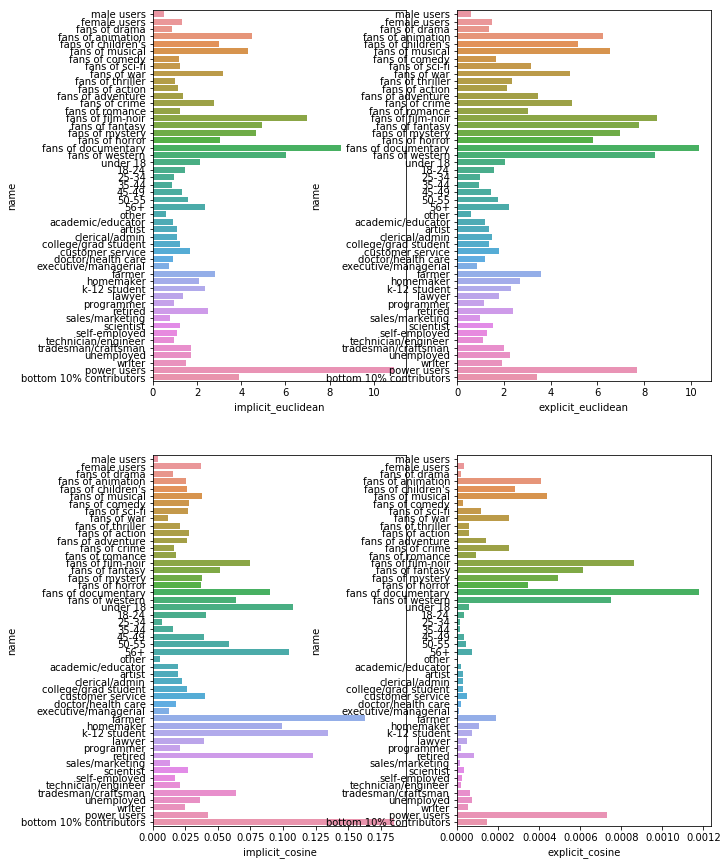

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(10,15))
sns.barplot(y='name', x='implicit_euclidean', data=df, ax=axes[0,0])
sns.barplot(y='name', x='explicit_euclidean', data=df, ax=axes[0,1])
sns.barplot(y='name', x='implicit_cosine', data=df, ax=axes[1,0])
sns.barplot(y='name', x='explicit_cosine', data=df, ax=axes[1,1])
plt.show()

In [20]:
total = len(users_df.index)
print('total users', total)
for group in group_by_genre(users_df, ratings_df, dfs['movies'], 'ml-1m'):
    users = sorted(list(set(group['df'].user_id)))
    print(group['name'], len(users))

total users 6040
Fans of Drama excluded using threshold 4 2047
Fans of Animation excluded using threshold 4 375
Fans of Children's excluded using threshold 4 339
Fans of Musical excluded using threshold 4 374
Fans of Comedy excluded using threshold 4 1159
Fans of Sci-Fi excluded using threshold 4 643
Fans of War excluded using threshold 4 1004
Fans of Thriller excluded using threshold 4 1045
Fans of Action excluded using threshold 4 948
Fans of Adventure excluded using threshold 4 617
Fans of Crime excluded using threshold 4 715
Fans of Romance excluded using threshold 4 825
Fans of Film-Noir excluded using threshold 4 288
Fans of Fantasy excluded using threshold 4 140
Fans of Mystery excluded using threshold 4 326
Fans of Horror excluded using threshold 4 192
Fans of Documentary excluded using threshold 4 87
Fans of Western excluded using threshold 4 140


In [21]:
from scipy.stats import pearsonr

print(pearsonr(df['like-boycott-ratio'], df['non-boycott-ratio']))

print('\n===')
for distance in [
    'explicit_cosine', 'explicit_euclidean',
    'implicit_cosine', 'implicit_euclidean',
]:
    for ratio in [
        'like-boycott-ratio', 'non-boycott-ratio'
    ]:
        x = pearsonr(df[distance], df[ratio])
        print(distance, ratio)
        print(x)
        print('\n')

(-0.3503180991381935, 0.012629092021123561)

===
explicit_cosine like-boycott-ratio
(0.041426439963802665, 0.775151742834866)


explicit_cosine non-boycott-ratio
(0.41250513804777417, 0.0029120350850693217)


explicit_euclidean like-boycott-ratio
(0.08185609921957415, 0.5719921391315814)


explicit_euclidean non-boycott-ratio
(0.33299127942746465, 0.018131480924301405)


implicit_cosine like-boycott-ratio
(0.722375163155732, 3.1821683416753448e-09)


implicit_cosine non-boycott-ratio
(-0.549409259839669, 3.5948978760848426e-05)


implicit_euclidean like-boycott-ratio
(0.15177460489328579, 0.2927194943707682)


implicit_euclidean non-boycott-ratio
(0.32623619933357795, 0.020769506831102378)




C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


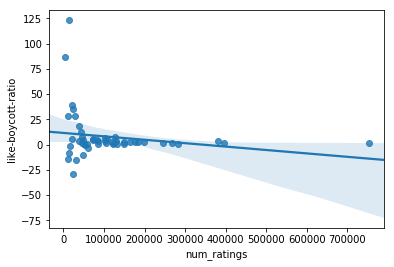

(0.722375163155732, 3.1821683416753448e-09)
    implicit_cosine  like-boycott-ratio                     name
0          0.003839            1.315362               male users
27         0.005867            3.317203                    other
22         0.007190            1.266061                    25-34
8          0.011929            1.581351              fans of war
34         0.012163            1.665144     executive/managerial
41         0.013496          -10.621084          sales/marketing
2          0.015235            0.954662            fans of drama
23         0.015831            2.041250                    35-44
12         0.015984            2.399018            fans of crime
43         0.016867            1.490205            self-employed
33         0.017846           18.149932       doctor/health care
13         0.017868            2.398836          fans of romance
29         0.019606            0.425076                   artist
28         0.019752            0.947292       

In [22]:
sns.regplot(x='num_ratings', y='like-boycott-ratio', data=df)
plt.show()
print(pearsonr(df['implicit_cosine'], df['like-boycott-ratio']))
print(df[['implicit_cosine', 'like-boycott-ratio', 'name']].sort_values('implicit_cosine'))

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


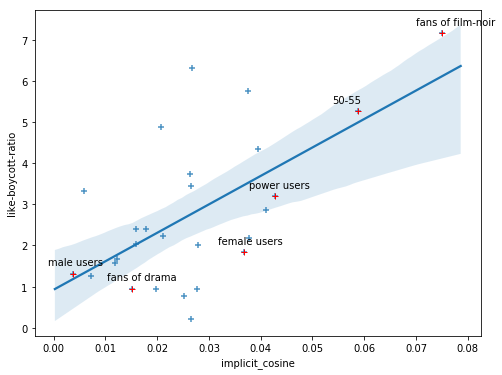

(0.6083824537124355, 0.0007601392891593542)
    implicit_cosine  num_ratings  like-boycott-ratio                  name
0          0.003839       753769            1.315362            male users
27         0.005867       130499            3.317203                 other
22         0.007190       395556            1.266061                 25-34
8          0.011929       268388            1.581351           fans of war
34         0.012163       105425            1.665144  executive/managerial
2          0.015235       283280            0.954662         fans of drama
23         0.015831       199003            2.041250                 35-44
12         0.015984       177567            2.399018         fans of crime
13         0.017868       149309            2.398836       fans of romance
28         0.019752        85351            0.947292     academic/educator
44         0.020683        72816            4.871884   technician/engineer
9          0.021235       164050            2.221265    

In [65]:
fig, ax = plt.subplots(1,1, figsize=(8, 6))

filtered = df[df.num_ratings >= 61000]
sns.regplot(
    x='implicit_cosine', y='like-boycott-ratio', data=filtered,
    ax=ax, marker="+"
)

def label_point(x, y, val, ax, names):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if str(point['val']) in names:
            ax.text(
                point['x']-.005, point['y']+0.2, str(point['val']), 
            )
            ax.plot(point['x'], point['y'], 'r+')

label_point(
    filtered.implicit_cosine, filtered['like-boycott-ratio'], filtered.name, plt.gca(),
    names=['male users', 'female users', 'fans of film-noir', 'power users', 'fans of drama', '50-55']
)  

plt.show()
print(pearsonr(filtered['implicit_cosine'], filtered['like-boycott-ratio']))
print(filtered[['implicit_cosine', 'num_ratings', 'like-boycott-ratio', 'name']].sort_values('implicit_cosine'))

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


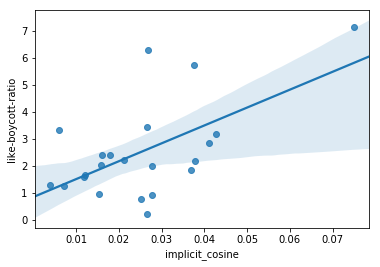

(0.5893487772656341, 0.003898111700821753)
    implicit_cosine  num_ratings  like-boycott-ratio                  name
0          0.003839       753769            1.315362            male users
27         0.005867       130499            3.317203                 other
22         0.007190       395556            1.266061                 25-34
8          0.011929       268388            1.581351           fans of war
34         0.012163       105425            1.665144  executive/managerial
2          0.015235       283280            0.954662         fans of drama
23         0.015831       199003            2.041250                 35-44
12         0.015984       177567            2.399018         fans of crime
13         0.017868       149309            2.398836       fans of romance
9          0.021235       164050            2.221265      fans of thriller
3          0.025233       123314            0.785237     fans of animation
31         0.026490       131032            0.212488  col

In [27]:
large_boycotts = df[df.num_ratings > 1e5]

sns.regplot(x='implicit_cosine', y='like-boycott-ratio', data=large_boycotts)
plt.show()
print(pearsonr(large_boycotts['implicit_cosine'], large_boycotts['like-boycott-ratio']))
print(large_boycotts[['implicit_cosine', 'num_ratings', 'like-boycott-ratio', 'name']].sort_values('implicit_cosine'))

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


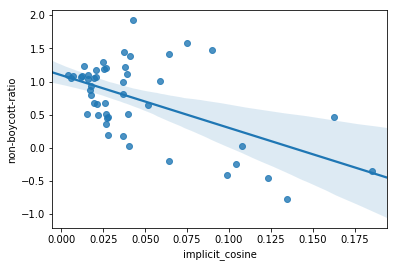

(-0.549409259839669, 3.5948978760848426e-05)
    implicit_cosine  non-boycott-ratio                     name
0          0.003839           1.103753               male users
27         0.005867           1.046106                    other
22         0.007190           1.090784                    25-34
8          0.011929           1.075421              fans of war
34         0.012163           1.082725     executive/managerial
41         0.013496           1.236501          sales/marketing
2          0.015235           0.517199            fans of drama
23         0.015831           1.093830                    35-44
12         0.015984           1.036400            fans of crime
43         0.016867           0.875103            self-employed
33         0.017846           0.795087       doctor/health care
13         0.017868           0.929715          fans of romance
29         0.019606           0.672230                   artist
28         0.019752           1.054578        academic/educ

In [28]:
sns.regplot(x='implicit_cosine', y='non-boycott-ratio', data=df)
plt.show()
print(pearsonr(df['implicit_cosine'], df['non-boycott-ratio']))
print(df[['implicit_cosine', 'non-boycott-ratio', 'name']].sort_values('implicit_cosine'))